In [1]:
!pip install torchview

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import torchvision
from torchsummary import summary
#from torchview import draw_graph
from transformers import MobileNetV1Config, MobileNetV1Model
from sklearn.utils.class_weight import compute_class_weight

In [2]:
dataset_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder'

In [5]:
def calculate_mean_std(dataset_path, batch_size=32):
    # Add resizing to ensure consistent image dimensions
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    total_sum = torch.zeros(3)
    total_squared_sum = torch.zeros(3)
    total_count = 0
    
    for inputs, _ in loader:
        # Flatten image batch 
        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        total_sum += inputs.sum(dim=(0, 2))
        total_squared_sum += (inputs ** 2).sum(dim=(0, 2))
        total_count += inputs.size(0) * inputs.size(2)  
    

    mean = total_sum / total_count
    std = torch.sqrt((total_squared_sum / total_count) - (mean ** 2))
    
    return mean.tolist(), std.tolist()

 
mean, std = calculate_mean_std(os.path.join(dataset_path, 'train'))
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.5000774264335632, 0.4557059407234192, 0.4074406027793884]
Std: [0.27882811427116394, 0.267927885055542, 0.27114740014076233]


In [3]:
mean = [0.5000774264335632, 0.4557059407234192, 0.4074406027793884]
std = [0.27882811427116394, 0.267927885055542, 0.27114740014076233]

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(224),   
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
'''
test_transform = transforms.Compose([
    transforms.Resize(320),  
    
    transforms.TenCrop(size=299),  
    transforms.Lambda(lambda crops: torch.stack([
        transforms.Normalize(mean, std)(transforms.ToTensor()(crop)) for crop in crops
    ]))
])
'''
test_transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
train_data = datasets.ImageFolder(os.path.join(dataset_path, 'train'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(dataset_path, 'test'), transform = test_transform)
val_data = datasets.ImageFolder(os.path.join(dataset_path, 'valid'), transform = test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 64, shuffle= True, pin_memory= False)
test_loader = DataLoader(test_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
val_loader = DataLoader(val_data,
                         batch_size= 64, shuffle= False, pin_memory= False)
classes = ['Angry','Sad','happy','Other']
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')
print(f'Number of validation images: {len(val_data)}')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 1000
Number of test images: 38
Number of validation images: 36
Available processor cuda


In [6]:
class DepthWiseSeperable(nn.Module):

    def __init__(self, in_channels , out_channels , stride ):

        super(DepthWiseSeperable,self).__init__()
        self.depthwise = nn.Conv2d(in_channels = in_channels , out_channels = in_channels , stride = stride , padding = 1, kernel_size = 3 , groups=in_channels , bias = False)
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , stride = 1 , padding = 0, kernel_size = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self,x):

        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x


In [7]:
class MyMobileNetV1(nn.Module):
    
    def __init__(self, num_classes=4):
        
        super(MyMobileNetV1, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias = False),
            nn.ReLU6(inplace=True),
            nn.BatchNorm2d(32),
        )
        
        self.features = nn.Sequential(
            self.features,
            DepthWiseSeperable(32, 64, 1),
            DepthWiseSeperable(64, 128, 2),
            DepthWiseSeperable(128, 128, 1),
            DepthWiseSeperable(128, 256, 2),
            DepthWiseSeperable(256, 256, 1),
            DepthWiseSeperable(256, 512, 2),
            
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),
            DepthWiseSeperable(512, 512, 1),

            DepthWiseSeperable(512, 1024, 2),
            DepthWiseSeperable(1024, 1024, 1)

        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = MyMobileNetV1()


In [8]:
def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=1e-5):
    model = model.to(device)

    all_labels = []
    for _, labels in train_loader:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_labels),
        y=all_labels
    )
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        if epoch % 2 == 0:
            learning_rate = learning_rate / 10
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Intermediate logging
            if (i + 1) % 32 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        # Calculate epoch-level training metrics
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    print('Training complete.')

In [9]:
def evaluate_model(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()  
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Plot Confusion Matrix as Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

Epoch [1/10], Train Loss: 1.4652, Validation Loss: 1.6178, Train Accuracy: 27.60%, Validation Accuracy: 16.67%
Epoch [2/10], Train Loss: 1.4223, Validation Loss: 1.8906, Train Accuracy: 27.70%, Validation Accuracy: 25.00%
Epoch [3/10], Train Loss: 1.4089, Validation Loss: 1.4166, Train Accuracy: 33.00%, Validation Accuracy: 27.78%
Epoch [4/10], Train Loss: 1.4111, Validation Loss: 1.4303, Train Accuracy: 29.20%, Validation Accuracy: 25.00%
Epoch [5/10], Train Loss: 1.3661, Validation Loss: 1.9198, Train Accuracy: 34.40%, Validation Accuracy: 19.44%
Epoch [6/10], Train Loss: 1.3779, Validation Loss: 1.3542, Train Accuracy: 33.80%, Validation Accuracy: 44.44%
Epoch [7/10], Train Loss: 1.3463, Validation Loss: 1.3517, Train Accuracy: 36.20%, Validation Accuracy: 36.11%
Epoch [8/10], Train Loss: 1.3255, Validation Loss: 1.3967, Train Accuracy: 38.20%, Validation Accuracy: 33.33%
Epoch [9/10], Train Loss: 1.3225, Validation Loss: 1.4721, Train Accuracy: 38.00%, Validation Accuracy: 38.89%
E

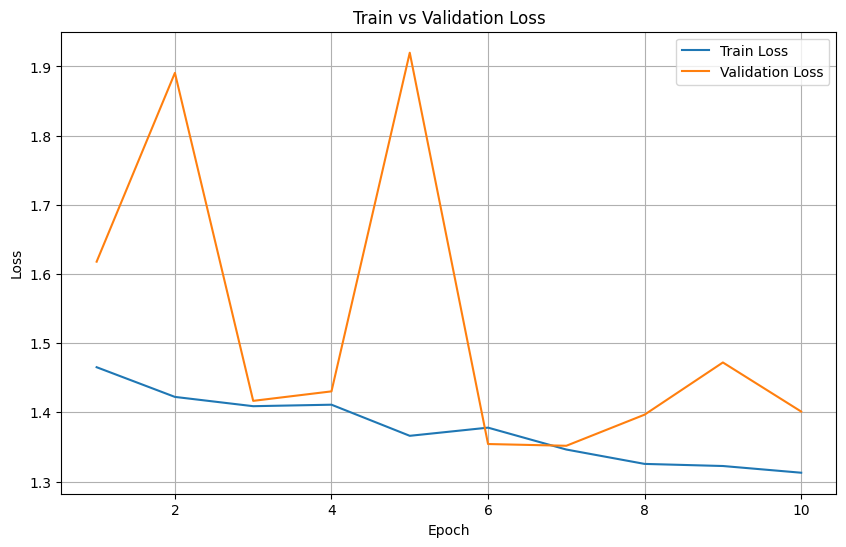

Training complete.


In [10]:
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
train_model(model, train_loader, val_loader, num_epochs, device,learning_rate)

Test Accuracy: 34.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.40      0.38        10
           1       0.10      0.17      0.12         6
           2       0.38      0.27      0.32        11
           3       0.56      0.45      0.50        11

    accuracy                           0.34        38
   macro avg       0.35      0.32      0.33        38
weighted avg       0.38      0.34      0.36        38


Confusion Matrix:
[[4 3 1 2]
 [3 1 1 1]
 [2 5 3 1]
 [2 1 3 5]]


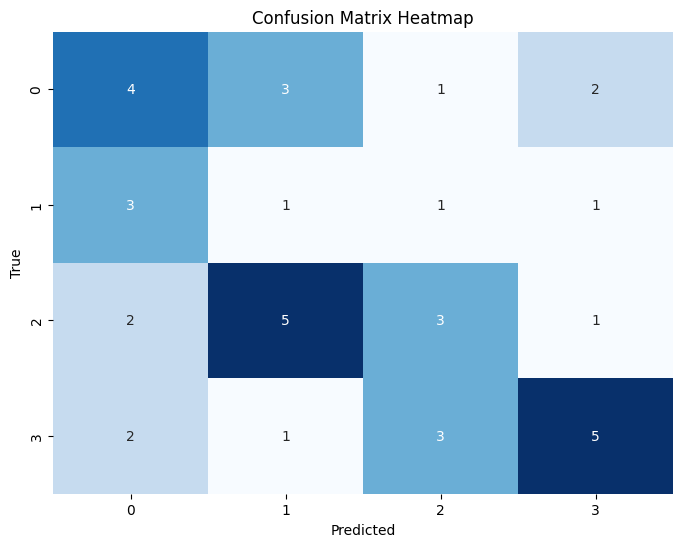

In [11]:
evaluate_model(model, test_loader,4)

In [12]:
configuration = MobileNetV1Config()

huggingfacemodel = MobileNetV1Model(configuration).to(device)

architecture = 'huggingfacemodel'

from torchsummary import summary
summary(huggingfacemodel, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
MobileNetV1ConvLayer-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
             ReLU6-7         [-1, 32, 112, 112]               0
MobileNetV1ConvLayer-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]           2,048
      BatchNorm2d-10         [-1, 64, 112, 112]             128
            ReLU6-11         [-1, 64, 112, 112]               0
MobileNetV1ConvLayer-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [

In [13]:
custom_model = MyMobileNetV1()

In [14]:
def transfer_weights(pretrained_model, custom_model):
    pretrained_layers = [layer for layer in pretrained_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]
    custom_layers = [layer for layer in custom_model.modules() if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d, nn.Linear))]

    for pretrained_layer, custom_layer in zip(pretrained_layers, custom_layers):
        # Check same type and shape
        if isinstance(pretrained_layer, type(custom_layer)) and pretrained_layer.weight.size() == custom_layer.weight.size():
            custom_layer.weight.data.copy_(pretrained_layer.weight.data)
            if hasattr(pretrained_layer, 'bias') and hasattr(custom_layer, 'bias'):
                if pretrained_layer.bias is not None and custom_layer.bias is not None:
                    custom_layer.bias.data.copy_(pretrained_layer.bias.data)
        else:
            print(f"Skipping incompatible layers: {pretrained_layer} -> {custom_layer}")


transfer_weights(huggingfacemodel, custom_model)

print("Weights transferred successfully!")

Weights transferred successfully!


In [15]:
model = custom_model

Epoch [1/10], Train Loss: 1.4331, Validation Loss: 19.2297, Train Accuracy: 27.80%, Validation Accuracy: 25.00%
Epoch [2/10], Train Loss: 1.4096, Validation Loss: 8.0171, Train Accuracy: 30.40%, Validation Accuracy: 16.67%
Epoch [3/10], Train Loss: 1.3854, Validation Loss: 1.4325, Train Accuracy: 31.80%, Validation Accuracy: 27.78%
Epoch [4/10], Train Loss: 1.3883, Validation Loss: 1.8484, Train Accuracy: 31.30%, Validation Accuracy: 25.00%
Epoch [5/10], Train Loss: 1.3553, Validation Loss: 1.3391, Train Accuracy: 33.60%, Validation Accuracy: 36.11%
Epoch [6/10], Train Loss: 1.3429, Validation Loss: 2.1180, Train Accuracy: 36.00%, Validation Accuracy: 27.78%
Epoch [7/10], Train Loss: 1.3543, Validation Loss: 1.8730, Train Accuracy: 37.50%, Validation Accuracy: 25.00%
Epoch [8/10], Train Loss: 1.3259, Validation Loss: 1.4598, Train Accuracy: 36.40%, Validation Accuracy: 41.67%
Epoch [9/10], Train Loss: 1.3097, Validation Loss: 1.4221, Train Accuracy: 37.30%, Validation Accuracy: 33.33%


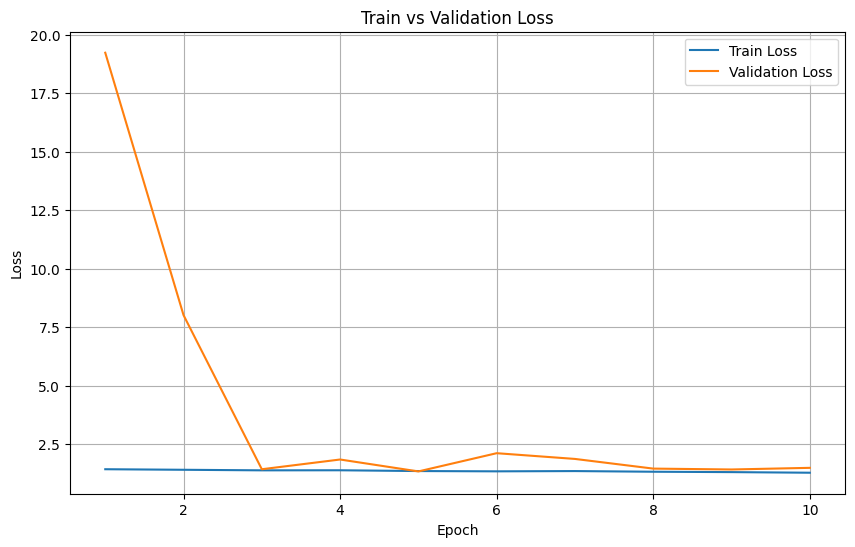

Training complete.


In [17]:
num_epochs = 10
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
train_model(custom_model, train_loader, val_loader, num_epochs, device,learning_rate)

Test Accuracy: 34.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40        10
           1       0.00      0.00      0.00         6
           2       0.30      0.27      0.29        11
           3       0.38      0.45      0.42        11

    accuracy                           0.34        38
   macro avg       0.25      0.31      0.28        38
weighted avg       0.29      0.34      0.31        38


Confusion Matrix:
[[5 0 1 4]
 [3 0 2 1]
 [5 0 3 3]
 [2 0 4 5]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


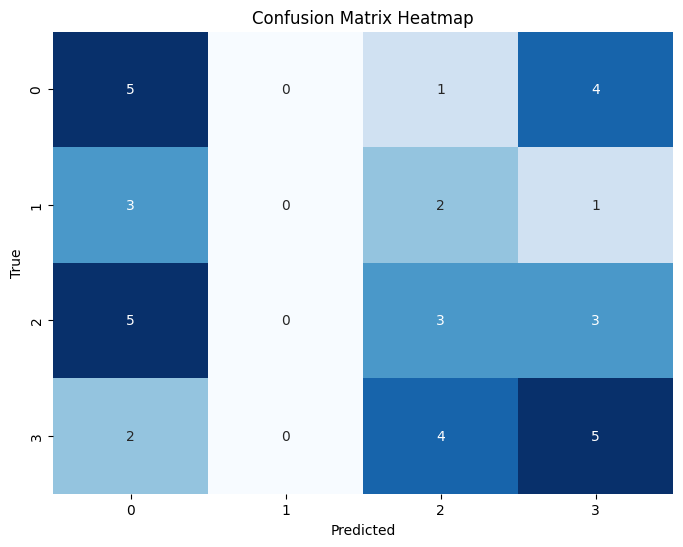

In [18]:
evaluate_model(custom_model, test_loader,4)